## Instance Segmentation with Mask R-CNN using Mobilenet V2 as backbone

Model: [Mask R-CNN](https://arxiv.org/abs/1703.06870)

Backbone: [Mobilnet V2](https://arxiv.org/abs/1801.04381)

Models: [TF Model Package](https://pypi.org/project/tf-models-official/)

Dataset: [LVIS](https://www.tensorflow.org/datasets/catalog/lvis) : A dataset for large vocabulary instance segmentation

Note: LVIS uses the COCO 2017 train, validation, and test image sets. If you have already downloaded the COCO images, you only need to download the LVIS annotations. LVIS val set contains images from COCO 2017 train in addition to the COCO 2017 val split.

Earnings:
- Use models from the TensorFlow Models package.
- Train/Fine-tune a pre-built Mask R-CNN with mobilenet as backbone for Object Detection and Instance Segmentation
- Export the trained/tuned Mask R-CNN model

In [1]:
! pip install -U -q "tf-models-official"
! pip install -U -q remotezip tqdm opencv-python einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 46.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does 

In [2]:
import os
import io
import json
import tqdm
import shutil
import pprint
import pathlib
import tempfile
import requests
import collections
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from etils import epath
from IPython import display
from urllib.request import urlopen

#=======================================

import orbit
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_datasets as tfds

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.data import tfrecord_lib
from official.vision.serving import export_saved_model_lib
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
from official.vision.data.create_coco_tf_record import coco_annotations_to_lists

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.13.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Download subset of LVIS dataset

[LVIS Dataset](https://www.lvisdataset.org/dataset)

In [3]:
# Training Set
!wget https://dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip  # Download LVS Training File
!unzip -q lvis_v1_train.json.zip                                  # Unzip downloaded file
!rm lvis_v1_train.json.zip                                        # Remove downloaded file

# Validation Set
!wget https://dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip  # Download LVS Validation File
!unzip -q lvis_v1_val.json.zip                                  # Unzip downloaded file
!rm lvis_v1_val.json.zip                                        # Remove downloaded file

# Test Set
!wget https://dl.fbaipublicfiles.com/LVIS/lvis_v1_image_info_test_dev.json.zip  # Download LVS Test File
!unzip -q lvis_v1_image_info_test_dev.json.zip                                  # Unzip downloaded file
!rm lvis_v1_image_info_test_dev.json.zip                                        # Remove downloaded file

--2023-08-28 13:33:04--  https://dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.88, 13.224.2.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350264821 (334M) [application/zip]
Saving to: ‘lvis_v1_train.json.zip’

lvis_v1_train.json. 100%[===================>] 334.04M  32.8MB/s    in 9.6s    

2023-08-28 13:33:14 (34.9 MB/s) - ‘lvis_v1_train.json.zip’ saved [350264821/350264821]

--2023-08-28 13:33:29--  https://dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.88, 13.224.2.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64026968 (61M) [application/zip]
Saving to: ‘lvis_v1_val.json.zip’

lvis_v1_val.json.zi 100%[

In [4]:
# @title Download annotation files
# !wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip
# !unzip -q lvis_v1_train.json.zip
# !rm lvis_v1_train.json.zip
#
# !wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip
# !unzip -q lvis_v1_val.json.zip
# !rm lvis_v1_val.json.zip
#
# !wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_image_info_test_dev.json.zip
# !unzip -q lvis_v1_image_info_test_dev.json.zip
# !rm lvis_v1_image_info_test_dev.json.zip

In [4]:
# Annotations with invalid bounding boxes. Will not be used.
_INVALID_ANNOTATIONS = [
    # Train split.
    662101,
    81217,
    462924,
    227817,
    29381,
    601484,
    412185,
    504667,
    572573,
    91937,
    239022,
    181534,
    101685,
    # Validation split.
    36668,
    57541,
    33126,
    10932,
]

In [5]:
def get_category_map(annotation_path, num_classes):
  with epath.Path(annotation_path).open() as f:
      data = json.load(f)

  category_map = {id+1: {'id': cat_dict['id'],
                       'name': cat_dict['name']}
                  for id, cat_dict in enumerate(data['categories'][:num_classes])}
  return category_map

In [6]:
class LvisAnnotation:
  """LVIS annotation helper class.
  The format of the annations is explained on
  https://www.lvisdataset.org/dataset.
  """

  def __init__(self, annotation_path):
    with epath.Path(annotation_path).open() as f:
      data = json.load(f)
    self._data = data

    img_id2annotations = collections.defaultdict(list)
    for a in self._data.get('annotations', []):
      if a['category_id'] in category_ids:
        img_id2annotations[a['image_id']].append(a)
    self._img_id2annotations = {
        k: list(sorted(v, key=lambda a: a['id']))
        for k, v in img_id2annotations.items()
    }

  @property
  def categories(self):
    """Return the category dicts, as sorted in the file."""
    return self._data['categories']

  @property
  def images(self):
    """Return the image dicts, as sorted in the file."""
    sub_images = []
    for image_info in self._data['images']:
      if image_info['id'] in self._img_id2annotations:
        sub_images.append(image_info)
    return sub_images

  def get_annotations(self, img_id):
    """Return all annotations associated with the image id string."""
    # Some images don't have any annotations. Return empty list instead.
    return self._img_id2annotations.get(img_id, [])

In [7]:
def _generate_tf_records(prefix, images_zip, annotation_file, num_shards=5):
    """Generate TFRecords."""

    lvis_annotation = LvisAnnotation(annotation_file)

    def _process_example(prefix, image_info, id_to_name_map):
      # Search image dirs.
      filename = pathlib.Path(image_info['coco_url']).name
      image = tf.io.read_file(os.path.join(IMGS_DIR, filename))
      instances = lvis_annotation.get_annotations(img_id=image_info['id'])
      instances = [x for x in instances if x['id'] not in _INVALID_ANNOTATIONS]
      # print([x['category_id'] for x in instances])
      is_crowd = {'iscrowd': 0}
      instances = [dict(x, **is_crowd) for x in instances]
      neg_category_ids = image_info.get('neg_category_ids', [])
      not_exhaustive_category_ids = image_info.get(
          'not_exhaustive_category_ids', []
      )
      data, _ = coco_annotations_to_lists(instances,
                                          id_to_name_map,
                                          image_info['height'],
                                          image_info['width'],
                                          include_masks=True)
      # data['category_id'] = [id-1 for id in data['category_id']]
      keys_to_features = {
          'image/encoded':
              tfrecord_lib.convert_to_feature(image.numpy()),
          'image/filename':
               tfrecord_lib.convert_to_feature(filename.encode('utf8')),
          'image/format':
              tfrecord_lib.convert_to_feature('jpg'.encode('utf8')),
          'image/height':
              tfrecord_lib.convert_to_feature(image_info['height']),
          'image/width':
              tfrecord_lib.convert_to_feature(image_info['width']),
          'image/source_id':
              tfrecord_lib.convert_to_feature(str(image_info['id']).encode('utf8')),
          'image/object/bbox/xmin':
              tfrecord_lib.convert_to_feature(data['xmin']),
          'image/object/bbox/xmax':
              tfrecord_lib.convert_to_feature(data['xmax']),
          'image/object/bbox/ymin':
              tfrecord_lib.convert_to_feature(data['ymin']),
          'image/object/bbox/ymax':
              tfrecord_lib.convert_to_feature(data['ymax']),
          'image/object/class/text':
              tfrecord_lib.convert_to_feature(data['category_names']),
          'image/object/class/label':
              tfrecord_lib.convert_to_feature(data['category_id']),
          'image/object/is_crowd':
              tfrecord_lib.convert_to_feature(data['is_crowd']),
          'image/object/area':
              tfrecord_lib.convert_to_feature(data['area'], 'float_list'),
          'image/object/mask':
              tfrecord_lib.convert_to_feature(data['encoded_mask_png'])
      }
      # print(keys_to_features['image/object/class/label'])
      example = tf.train.Example(
          features=tf.train.Features(feature=keys_to_features))
      return example



    # file_names = [f"{prefix}/{pathlib.Path(image_info['coco_url']).name}"
    #               for image_info in lvis_annotation.images]
    # _extract_images(images_zip, file_names)
    writers = [
        tf.io.TFRecordWriter(
            tf_records_dir + prefix +'-%05d-of-%05d.tfrecord' % (i, num_shards))
        for i in range(num_shards)
    ]
    id_to_name_map = {cat_dict['id']: cat_dict['name']
                      for cat_dict in lvis_annotation.categories[:NUM_CLASSES]}
    # print(id_to_name_map)
    for idx, image_info in enumerate(tqdm.tqdm(lvis_annotation.images)):
      img_data = requests.get(image_info['coco_url'], stream=True).content
      img_name = image_info['coco_url'].split('/')[-1]
      with open(os.path.join(IMGS_DIR, img_name), 'wb') as handler:
          handler.write(img_data)
      tf_example = _process_example(prefix, image_info, id_to_name_map)
      writers[idx % num_shards].write(tf_example.SerializeToString())

    del lvis_annotation

In [8]:
NUM_CLASSES = 3

In [9]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name, dest):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall(dest)
  zip_ref.close()

In [10]:
_URLS = {
    'train_images': 'http://images.cocodataset.org/zips/train2017.zip',
    'validation_images': 'http://images.cocodataset.org/zips/val2017.zip',
    'test_images': 'http://images.cocodataset.org/zips/test2017.zip',
}

In [15]:
train_prefix = 'train'
valid_prefix = 'val'

train_annotation_path = './lvis_v1_train.json'
valid_annotation_path = './lvis_v1_val.json'

IMGS_DIR = './lvis_sub_dataset/'
# tf_records_dir = './lvis_tfrecords/'
tf_records_dir = '/content/content/lvis_tfrecords/'

In [16]:
unzip_data("/content/drive/MyDrive/MASTER/Master_Thesis/Mask_RCNN/lvis_tfrecords.zip", "/content")

In [17]:
if not os.path.exists(IMGS_DIR):
  os.mkdir(IMGS_DIR)

if not os.path.exists(tf_records_dir):
  os.mkdir(tf_records_dir)

In [18]:
category_index = get_category_map(valid_annotation_path, NUM_CLASSES)
category_ids = list(category_index.keys())

In [19]:
category_ids

[1, 2, 3]

### Generate TF Records for Training and Validation sets

In [9]:
# Below helper function are taken from github tensorflow dataset lvis
# https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/lvis/lvis_dataset_builder.py

# IF you have generated TFRecords file for Training images do not run this code
# _generate_tf_records(train_prefix, _URLS['train_images'], train_annotation_path)

In [10]:
# IF you have generated TFRecords file for Validation images do not run this code
# _generate_tf_records(valid_prefix, _URLS['validation_images'], valid_annotation_path)

In [11]:
# zip tfrecord files for downloading
# !zip -r lvis_tfrecords.zip /content/lvis_tfrecords/

### Configure Mask RCNN Resnet FPN (Feature Pyramid Network) COCO model for custom Dataset

In Model Garden, the collections of parameters that define a model are called `configs`. Model Garden can create a config based on a known set of parameters via a factory.

Use the `retinanet_mobilenet_coco` experiment configuration, as defined by [tfm.vision.configs.maskrcnn.maskrcnn_mobilenet_coco](https://www.tensorflow.org/api_docs/python/tfm/vision/configs/maskrcnn/maskrcnn_mobilenet_coco).

All experiements

The configuration defines an experiment to train a Mask R-CNN model with mobilenet as backbone and FPN as decoder. Default Congiguration is trained on [COCO](https://cocodataset.org/#home) train2017 and evaluated on [COCO](https://cocodataset.org/#home) val2017.  

There are also other alternative experiments available such as [maskrcnn_resnetfpn_coco](https://www.tensorflow.org/api_docs/python/tfm/vision/configs/maskrcnn/maskrcnn_resnetfpn_coco), [maskrcnn_spinenet_coco](https://www.tensorflow.org/api_docs/python/tfm/vision/configs/maskrcnn/maskrcnn_spinenet_coco) and more. One can switch to them by changing the experiment name argument to the get_exp_config function.

In [20]:
train_data_input_path = '/content/content/lvis_tfrecords/train*'
valid_data_input_path = '/content/content/lvis_tfrecords/val*'
test_data_input_path = '/content/content/lvis_tfrecords/test*'
# train_data_input_path = './lvis_tfrecords/train*'
# valid_data_input_path = './lvis_tfrecords/val*'
# test_data_input_path = './lvis_tfrecords/test*'
model_dir = './trained_model/'
export_dir ='./exported_model/'

In [21]:
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

In [22]:
exp_config = exp_factory.get_exp_config('maskrcnn_mobilenet_coco')

`gsutil` is a Python application that lets you access Cloud Storage from the command line. You can use gsutil to do a wide range of bucket and object management tasks, including:

* Creating and deleting buckets.
* Uploading, downloading, and deleting objects.
* Listing buckets and objects.
* Moving, copying, and renaming objects.
* Editing object and bucket ACLs.

In [23]:
model_ckpt_path = './model_ckpt/'
if not os.path.exists(model_ckpt_path):
  os.mkdir(model_ckpt_path)

!gsutil cp gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.data-00000-of-00001 './model_ckpt/'
!gsutil cp gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.index './model_ckpt/'

Copying gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.data-00000-of-00001...
/ [1 files][ 26.9 MiB/ 26.9 MiB]                                                
Operation completed over 1 objects/26.9 MiB.                                     
Copying gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.index...
/ [1 files][  7.5 KiB/  7.5 KiB]                                                
Operation completed over 1 objects/7.5 KiB.                                      


### Adjust the model and Dataset Configurations

In [24]:
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 64
AUG_SCALE_MAX = 1.0
AUG_SCALE_MIN = 1.0
HEIGHT, WIDTH = 256, 256
IMG_SHAPE = [HEIGHT, WIDTH, 3]

In [25]:
# Backbone Config
exp_config.task.annotation_file = None
exp_config.task.freeze_backbone = True
exp_config.task.init_checkpoint = "./model_ckpt/ckpt-180648"
exp_config.task.init_checkpoint_modules = "backbone"

# Model Config
exp_config.task.model.num_classes = NUM_CLASSES + 1
exp_config.task.model.input_size = IMG_SHAPE

# Training Data Config
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = BATCH_SIZE
exp_config.task.train_data.shuffle_buffer_size = SHUFFLE_BUFFER_SIZE
exp_config.task.train_data.parser.aug_scale_max = AUG_SCALE_MAX  # a float with range between [1.0, inf] representing maximum random scale applied for training scale jittering.
exp_config.task.train_data.parser.aug_scale_min = AUG_SCALE_MIN  # a float with range between [0, 1.0] representing minimum random scale applied for training scale jittering.

# Validation Data Config
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = BATCH_SIZE

### Adjust Trainer Configuration

In [26]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'

This may be broken in Colab.


In [27]:
TRAIN_STEPS       = 2000
STEPS_PER_LOOP    = 200  # steps_per_loop = num_of_training_examples // train_batch_size
SUMMARY_INTERVAL  = 200
CHECKP_INTERVAL   = 200  # Checkpoint interval
VAL_INTERVAL      = 200  # Validtaion Interval
VAL_STEPS         = 200  # Validtaion Steps
WARMUP_STEPS      = 200  # Warmup Steps
INIT_LR           = 0.07 # Initial Learning rate
WARMUP_LR         = 0.05 # Warmup Learning rate

In [28]:
train_steps = TRAIN_STEPS
exp_config.trainer.steps_per_loop = STEPS_PER_LOOP

exp_config.trainer.summary_interval = SUMMARY_INTERVAL
exp_config.trainer.checkpoint_interval = CHECKP_INTERVAL
exp_config.trainer.validation_interval = VAL_INTERVAL
exp_config.trainer.validation_steps =  VAL_STEPS # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = WARMUP_STEPS
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
# The learning rate warmup technique gradually increases the learning rate from an initial value to the desired
# learning rate. The initial learning rate is typically set to a small value, such as 0.01, and the desired
# learning rate is set to the value determined by the learning rate schedule. The learning rate warmup technique
# is useful when the model is complex and the initial area of the loss function is large.
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = INIT_LR
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = WARMUP_LR

### Print the modified configurations

In [29]:
pp.pprint(exp_config.as_dict())
display.Javascript("google.colab.output.setIframeHeight('500px');")

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'allowed_mask_class_ids': None,
                'annotation_file': None,
        

<IPython.core.display.Javascript object>

### Setup Distribution strategy

In [30]:
# Setting up the Strategy
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Create `Task` Object (`tf.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The Task object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.



In [31]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

### Visualize a batch of the data

In [32]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')

Instructions for updating:
Use fn_output_signature instead



images.shape: (8, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['anchor_boxes', 'image_info', 'rpn_score_targets', 'rpn_box_targets', 'gt_boxes', 'gt_classes', 'gt_outer_boxes', 'gt_masks'])


### Create Category Index Dictionary to map the labels to coressponding label names

In [33]:
tf_ex_decoder = TfExampleDecoder(include_mask=True)

### Helper Function for Visualizing the results from TFRecords

Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [34]:
def show_batch(raw_records):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30

  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    # print(decoded_tensors['groundtruth_instance_masks'].numpy().shape)
    # print(decoded_tensors.keys())
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        min_score_thresh=min_score_thresh,
        instance_masks=decoded_tensors['groundtruth_instance_masks'].numpy().astype('uint8'),
        line_thickness=4)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image-{i+1}")
  plt.show()

### Visualization of Train Data

The bounding box detection has three components

* Class label of the object detected.
* Percentage of match between predicted and ground truth bounding boxes.
* Instance Segmentation Mask

! Note: The reason of everything is 100% is because we are visualising the groundtruth

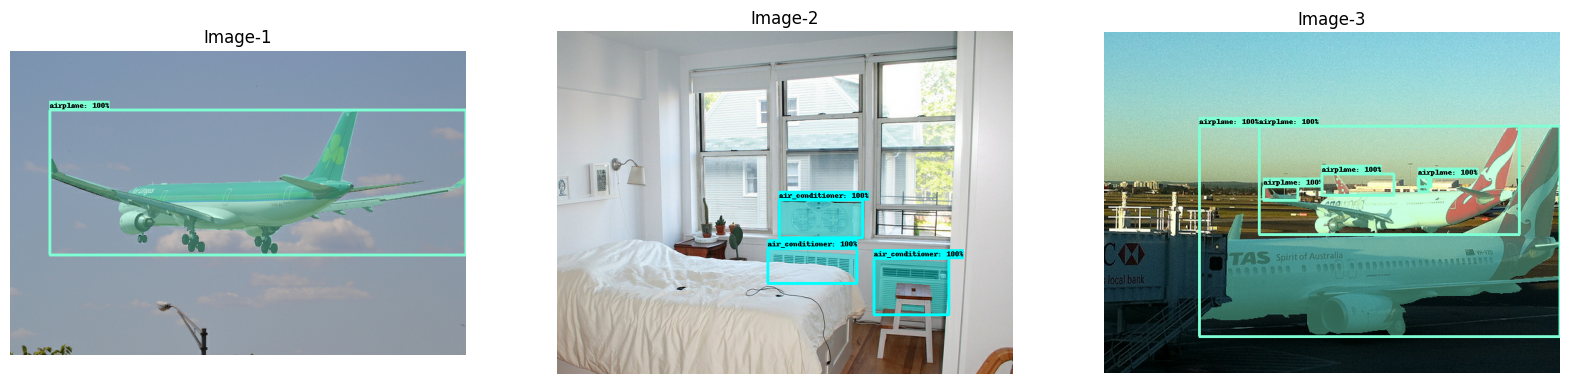

In [36]:
# A tf.int64 scalar tf.Tensor, representing the maximum number elements that will be buffered when prefetching.
# For example if you have 10000 images set buffer size to 1000. Thus first 1000 images will be shuffled first and
# free. Then the second group contains 1000 images will be shuffled
buffer_size = 100
num_of_examples = 3

train_tfrecords = tf.io.gfile.glob(exp_config.task.train_data.input_path)
raw_records = tf.data.TFRecordDataset(train_tfrecords).shuffle(buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records)

### Train and Evaluate

We follow the COCO challenge tradition to evaluate the accuracy of object detection based on mAP(mean Average Precision).

[COCO Detection Evaluation](https://cocodataset.org/#detection-eval)

**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted bounding box and ground truth bounding box.

In [37]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
restoring or initializing model...


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 200...
train | step:    200 | steps/sec:    1.2 | output: 
    {'frcnn_box_loss': 0.31745645,
     'frcnn_cls_loss': 0.058699857,
     'learning_rate': 0.06828698,
     'mask_loss': 0.5497466,
     'model_loss': 1.0659935,
     'rpn_box_loss': 0.06403567,
     'rpn_score_loss': 0.076055065,
     'total_loss': 1.3696877,
     'training_loss': 1.3696877}
saved checkpoint to ./trained_model/ckpt-200.
 eval | step:    200 | running 200 steps of evaluation...
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Preci

### Load Logs in tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "./trained_model"

### Saving the trained Model

The keras.Model object returned by `train_lib.run_experiment` expects the data to be `normalized` by the dataset loader using the `same mean` and `variance` statiscics in `preprocess_ops.normalize_image`(image, offset=MEAN_RGB, scale=STDDEV_RGB). This export function handles those details, so you can pass tf.uint8 images and get the correct results.



In [38]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
INFO:tensorflow:Assets written to: ./exported_model/assets


In [39]:
# zip exported model files for downloading
# !zip -r exported_model.zip /content/exported_model

  adding: content/exported_model/ (stored 0%)
  adding: content/exported_model/variables/ (stored 0%)
  adding: content/exported_model/variables/variables.index (deflated 76%)
  adding: content/exported_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/exported_model/fingerprint.pb (stored 0%)
  adding: content/exported_model/saved_model.pb (deflated 91%)
  adding: content/exported_model/assets/ (stored 0%)
  adding: content/exported_model/params.yaml (deflated 72%)


### Inference from Trained Model

In [40]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [41]:
def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### Visualize Test Data

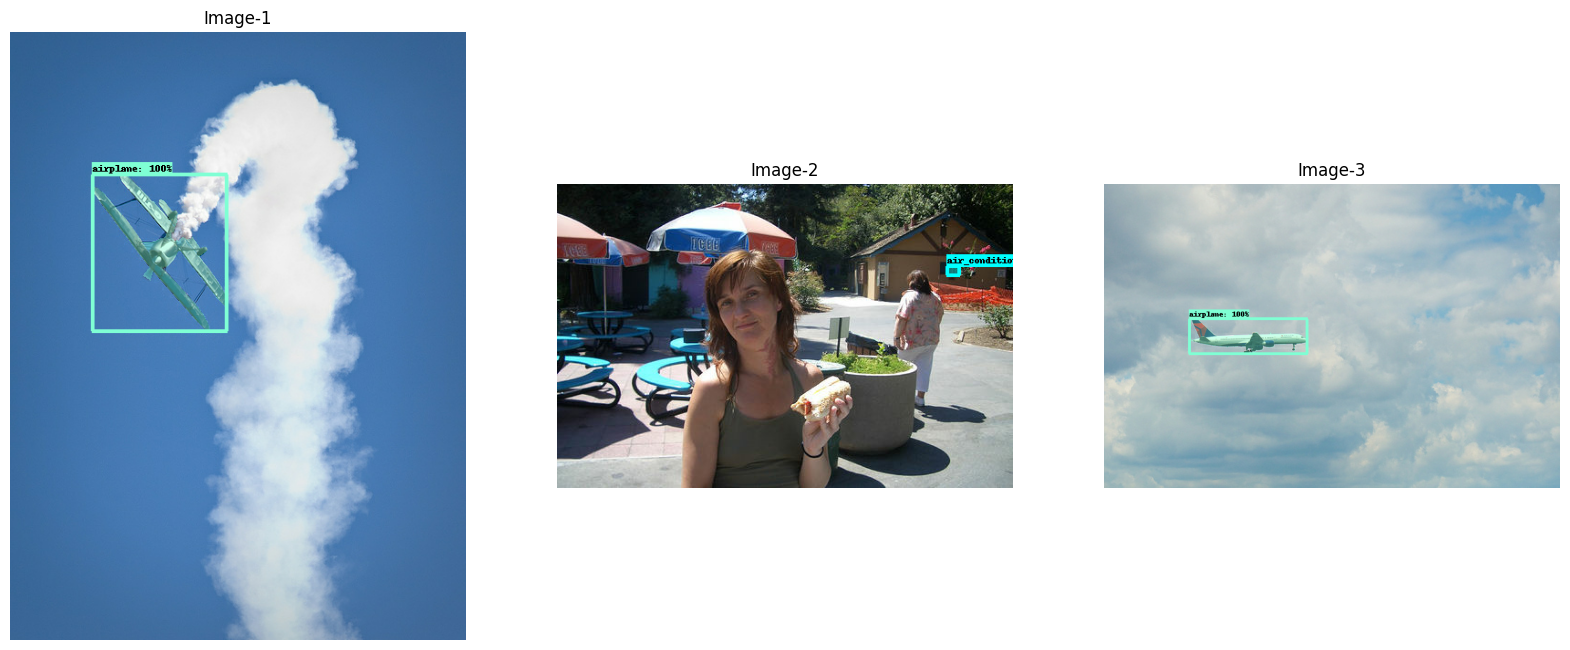

In [43]:
num_of_examples = 3

test_tfrecords = tf.io.gfile.glob(valid_data_input_path)
test_ds = tf.data.TFRecordDataset(test_tfrecords).take(num_of_examples)
show_batch(test_ds)

### Importing SavedModel

In [44]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### Visualize Predictions

In [46]:
def reframe_image_corners_relative_to_boxes(boxes):
  """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.
  The local coordinate frame of each box is assumed to be relative to
  its own for corners.
  Args:
    boxes: A float tensor of [num_boxes, 4] of (ymin, xmin, ymax, xmax)
      coordinates in relative coordinate space of each bounding box.
  Returns:
    reframed_boxes: Reframes boxes with same shape as input.
  """
  ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

  height = tf.maximum(ymax - ymin, 1e-4)
  width = tf.maximum(xmax - xmin, 1e-4)

  ymin_out = (0 - ymin) / height
  xmin_out = (0 - xmin) / width
  ymax_out = (1 - ymin) / height
  xmax_out = (1 - xmin) / width
  return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)

In [47]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
  """Transforms the box masks back to full image masks.
  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.
  Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.
  Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
  """
  resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""

    num_boxes = tf.shape(box_masks)[0]
    box_masks_expanded = tf.expand_dims(box_masks, axis=3)

    resized_crops = tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reframe_image_corners_relative_to_boxes(boxes),
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        method=resize_method,
        extrapolation_value=0)
    return tf.cast(resized_crops, box_masks.dtype)

  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
  return tf.squeeze(image_masks, axis=3)

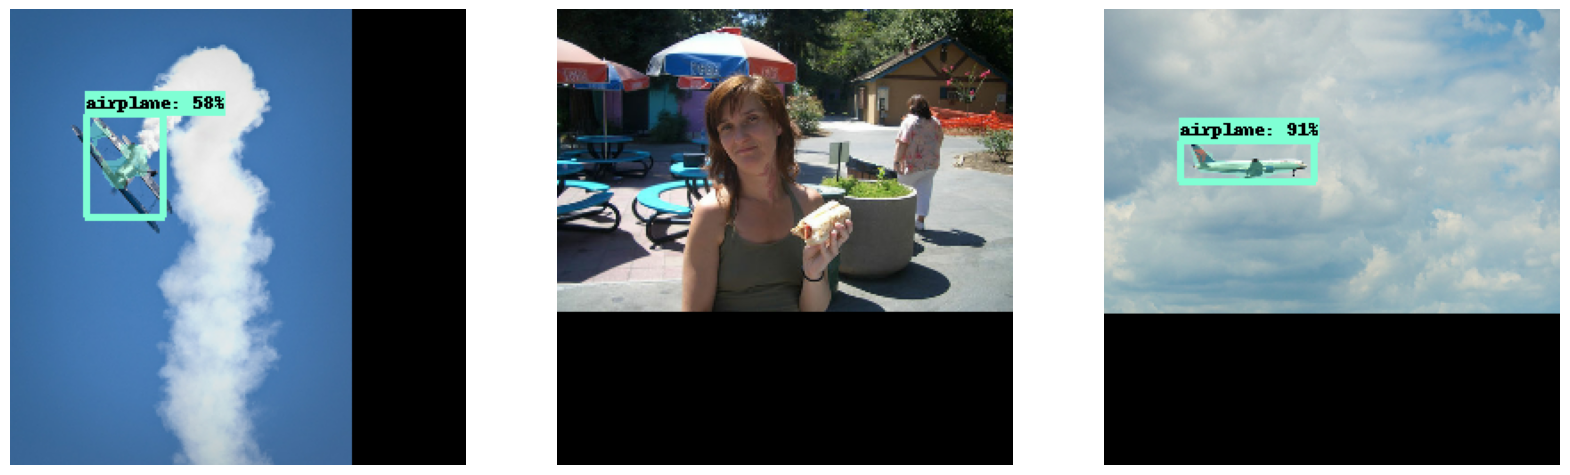

In [48]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.40 # Change minimum score for threshold to see all bounding boxes confidences

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)  # Prediction-Detection

  # Visualize detection and masks
  if 'detection_masks' in result:
    # we need to convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
    detection_masks_reframed = reframe_box_masks_to_image_masks(
              detection_masks, detection_boxes/256.0,
                image_np.shape[0], image_np.shape[1])
    detection_masks_reframed = tf.cast(
        detection_masks_reframed > min_score_thresh,
        np.uint8)

    result['detection_masks_reframed'] = detection_masks_reframed.numpy()
  visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        (result['detection_classes'][0] + 0).numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=4)

  plt.imshow(image_np)
  plt.axis("off")

plt.show()

### Reference

https://github.com/tensorflow/models/blob/master/docs/vision/instance_segmentation.ipynb

https://www.tensorflow.org/tfmodels/vision/instance_segmentation

https://arxiv.org/abs/1703.06870

https://arxiv.org/abs/1801.04381

https://pypi.org/project/tf-models-official/

https://www.tensorflow.org/datasets/catalog/lvis

https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset
